# Change Detection Tutorial

Tutorial for running change detection algorithms. 

This is done using randomly generated before and after images.


Steps: 
1. generate base DEM
    1. create after DEM by filling depressions (use defaults for now)
    1. add craters to after image (use defaults for now)
    1. hillshade both images (use azi param to control light direction)
    1. apply noise to both images
    1. apply affine to both images and use after affine on truth data (stick with offset differences for now, as it tends to be the most common registration error)
1. run before and after through a CD algorithm 
1. compute TPR and FPR 
    * TPR = TP/TP+FP
    * FPR = FP/FP+TP
    * IF function returns points, TP = point equals to or is contained by set of "truth" points/polys 1 pixel buffer. 
    * ELSE function returns polygons, TP = polygon has >50% intersection with "truth" poly. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis3.9.0'

from numpy import random
from scipy.ndimage.interpolation import zoom
import scipy

import os
import math

from PIL import Image
import numpy as np
from scipy.misc import imresize

import shapely
from shapely.geometry import Point, MultiPolygon, MultiPoint

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
import geopandas as gpd

from autocnet.utils.utils import bytescale, cartesian
from autocnet.examples import get_path
from autocnet.cg import change_detection as cd
from autocnet.cg import cg

# used just to produce parameterizations 
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = "object"
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [2]:
def generate_before_and_after(azi=(190, 190), noise_stddev=(0,0), alpha=1.0, nboulders=5):
    # Generate base DEM 
    before_dem = cd.generate_dem(alpha=alpha)
    
    # Generate Boulders
    before_dem, before_polys, after_dem, after_polys = cd.generate_boulder_field(before_dem, nboulders)

    # compute Depressions
    after_dem, change_poly = cd.compute_depression(after_dem, alpha=0.3, return_polygon=True)
    change_poly = shapely.ops.cascaded_union([change_poly, MultiPolygon(after_polys), MultiPolygon(before_polys)])
    
    # hillshade
    before_image = cd.hillshade(before_dem, azi=azi[0]).mean(axis=2)
    after_image = cd.hillshade(after_dem, azi=azi[1]).mean(axis=2)
    
    # add noise 
    before_image += np.random.normal(0, noise_stddev[0], before_image.shape)
    after_image += np.random.normal(0, noise_stddev[1], after_image.shape)
    
    # TODO: Add affine distortion 
    
    return before_image, after_image, change_poly


def plot_before_after_image(before_image, after_image, change_poly):
    diff = (after_image-before_image).astype(float)

    fig, axs = plt.subplots(2,2, figsize=(10,10))

    axs[0][0].imshow(before_image, cmap="bone")
    axs[0][0].set_title('"Before" Hillshade')
    axs[0][1].imshow(after_image, cmap="bone")
    axs[0][1].set_title('"After" Hillshade')

    axs[1][0].imshow(after_image, cmap='bone')

    if isinstance(change_poly, MultiPolygon):
        for geom in change_poly.geoms:    
            xs, ys = geom.exterior.xy    
            axs[1][0].fill(ys, xs, alpha=1, fc='black', ec='none')
    else: 
        xs, ys = change_poly.exterior.xy    
        axs[1][0].fill(ys, xs, alpha=1, fc='black', ec='none')
    axs[1][0].set_title("Change Polygons")

    axs[1][1].imshow(diff, cmap="magma")
    axs[1][1].set_title('Diff')
    plt.show()
    
    
def compute_cd_metrics(results, function_params, verbose=False):
    ny = len(results)
    
    if verbose: 
        fig, axs = plt.subplots(ny, 1)
        fig.set_figheight(5*ny)
        fig.set_figwidth(5)

    truth_poly = change_poly.buffer(1)
    scoresDf = pd.DataFrame(index=[str(p) for p in function_params], columns=["tpr", "fpr", "geom"])

    for i, coord in enumerate(results):
        res = results[i]
        df = res[0]
        # get true positives and false negatives
        true_positives = 0
        
        if(df.shape[0] is not 0 and isinstance(df.geometry[0], Point)):
            # needs to be within one pixel of truth
            for p in df.geometry:
                p = Point(p.y, p.x)
                if p.intersects(truth_poly):
                    true_positives+=1
        else:
            # geopandas likes to swap x,y
            sdf = df.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
            # get true positives and false negatives
            true_positives = 0
            for geom in sdf.geometry:
                for truth_geom in truth_poly.geoms:
                    if geom.intersection(truth_geom).area >= geom.area/5:
                        true_positives += 1
                        break
        
        print(true_positives, len(truth_poly))
        false_positives = len(df) - true_positives 
        TPR = max(true_positives/len(df) if df.shape[0] is not 0 else np.nan, 1)
        FPR = false_positives/len(df) if df.shape[0] is not 0 else np.nan
        
        scoresDf.loc[str(function_params[i])]["tpr"] = TPR
        scoresDf.loc[str(function_params[i])]["fpr"] = FPR
        
        if df.shape[0] is 0: 
            scoresDf.loc[str(function_params[i])]["geom"] = None
        else:
            try:
                scoresDf.loc[str(function_params[i])]["geom"] = MultiPoint(df.geometry)
            except:
                scoresDf.loc[str(function_params[i])]["geom"] = MultiPolygon(list(df.geometry))

        if verbose: 
            axs[i].set_title(f"score: {TPR}")
            axs[i].set(xlabel=f"", ylabel=f"")
            axs[i].imshow(after_image, cmap="bone", alpha=0.2)

            if isinstance(truth_poly, MultiPolygon):
                for geom in truth_poly.geoms:    
                    xs, ys = geom.exterior.xy    
                    axs[i].fill(ys, xs, alpha=0.5, fc='black', ec='none')
            else: 
                xs, ys = truth_poly.exterior.xy    
                axs[i].fill(ys, xs, alpha=0.5, fc='black', ec='none')
            
            try:
                axs[i].scatter(df.x, df.y, c="r", alpha=1, s=1)
            except:
                df.plot(ax=axs[i])
            
    if verbose: 
        plt.show()
    
    return scoresDf


## Generate before and after images 

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


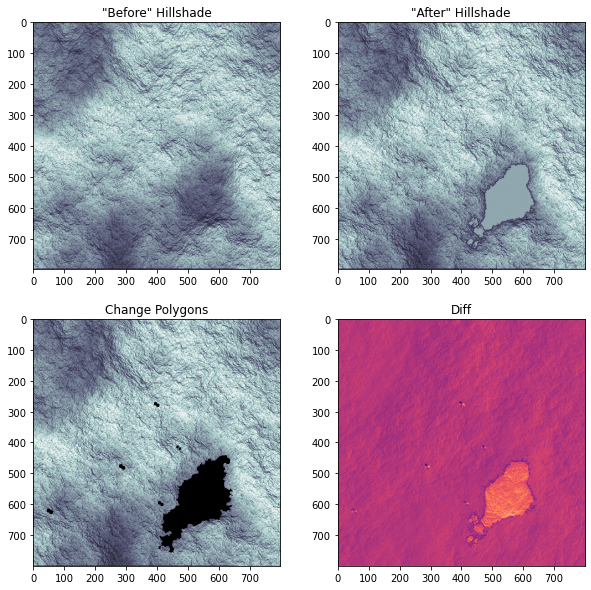

In [3]:
before_image, after_image, change_poly = generate_before_and_after(azi=(190, 215), noise_stddev=(1,2))
plot_before_after_image(before_image, after_image, change_poly)

# OKB

Simple change detection algorithm which produces an overlay image of change hotspots (i.e. a 2d histogram image of detected change density). This is done by running a ORB feature extractor over a diff or ratio image. 

**Cons** 
  1. Fails when change near edges of image 
  2. Not robust to textured FPs, lighting differences 
  3. Cannot capture large, uniform, changes 
  4. Poor automatic change detection, incabable of determining descrete changes 
  5. If nfeatures is too high, noise in the image begins to be picked up as FPs. 

**Pros**
  1. Simple, fast 
  2. Good "quick glance" change detection 

## Generate CD parameters

In [4]:
# Change these based on algorithm 

nfeatures = [1000, 2000]
scalefactor = [1.5]
nlevels = [3]
function_params = [dict(zip(["nfeatures", "scaleFactor", "nlevels"], ps)) for ps in cartesian_product(nfeatures, scalefactor, nlevels)] 

print(f"{len(function_params)}X1 Matrix")

2X1 Matrix


## Run OKB with Params

In [5]:
def image_diff_abs(arr1, arr2):
     return np.abs(cd.image_diff(arr1, arr2))

results = [cd.okubogar_detector(before_image, 
                                after_image, 
                                nbins=50, 
                                extractor_kwargs=params) for params in function_params]

## Plot results 

984 6
1780 6


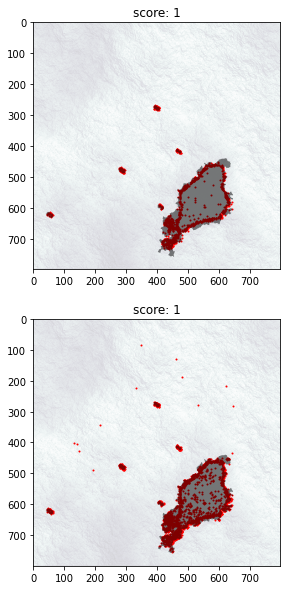

,tpr,fpr,geom
"{'nfeatures': 1000, 'scaleFactor': 1.5, 'nlevels': 3}",1,0.016,"(POINT (533 649), POINT (538 494), POINT (455 ..."
"{'nfeatures': 2000, 'scaleFactor': 1.5, 'nlevels': 3}",1,0.0198238,"(POINT (441 668), POINT (454 668), POINT (458 ..."


In [6]:
okb_results = compute_cd_metrics(results, function_params, True)
okb_results

# OKBM

Modified version of OKB, apply clustering to the output of OKB in order to identify contiguous globs. 

Pros: 
* Less ambiguous that OKB, descrete detectable change  
* Better for programmatic change detection  
* Good for large contiguous features  

Cons: 
* Does very poorly even with slight registration errors  
* Requires several super sensative hyper parameters  
* Min_samples requires you to know the smallest change 

## Generate CD Parameters

In [14]:
# Change Based on Algorithm
nfeatures = [500, 2000]
scalefactor = [1.5]
nlevels = [3]
extractor_params = [dict(zip(["nfeatures", "scaleFactor", "nlevels"], ps)) for ps in cartesian_product(nfeatures, scalefactor, nlevels)] 

min_samples = [10]
max_eps = [20]
xi = [.5]
eps = [.5]
cluster_params =  [dict(zip(["min_samples", "max_eps", "eps", "xi"], ps)) for ps in cartesian_product(min_samples, max_eps, eps, xi)] 

print(f"{len(cluster_params)}X{len(extractor_params)} Matrix")
function_params = cartesian_product(extractor_params, cluster_params)

1X2 Matrix


In [15]:
results = [cd.okbm_detector(before_image, 
                   after_image, 
                   extractor_kwargs=params[0], cluster_kwargs=params[1]) for params in function_params]

7 6
6 6


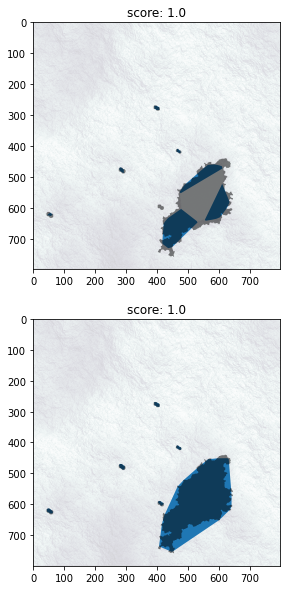

,tpr,fpr,geom
"[{'nfeatures': 500, 'scaleFactor': 1.5, 'nlevels': 3}\n {'min_samples': 10, 'max_eps': 20, 'eps': 0.5, 'xi': 0.5}]",1,0,"(POLYGON ((587 460, 569.25 461.25, 564 462, 55..."
"[{'nfeatures': 2000, 'scaleFactor': 1.5, 'nlevels': 3}\n {'min_samples': 10, 'max_eps': 20, 'eps': 0.5, 'xi': 0.5}]",1,0,"(POLYGON ((628 451, 595.5 451.5, 565.5 454.5, ..."


In [16]:
okbm_results = compute_cd_metrics(results, function_params, True)
okbm_results

# Blob

Detector desgined to find boulders. This works by detecting pairs of light and dark areas and correlates them with the expected sub solar azimuth angle to determine candidate pairs of lit and shadowed areas. Small brightened blobs with a nearby dark blob that are colinear to the subsolar azimuth is expected to be a boulder. The boulder is flagged as a change if it not in the same location in the before image as the after image. 

Pros: 
* Good at detecting boulders (though off by a few pixels...)
* faster than other algorithms 

Cons: 
* Does not detect large change
* sensative to bad registration 

## Generate CD Parameters

In [10]:
# Change Based on Algorithm
subtractive = [True]
min_sigma = [.25]
max_sigma = [.35, 1]
num_sigma = [4]
threshold = [.3]
overlap = [.5]
n_neighbors = [2]
angle_tolerance = [4]

function_params = [dict(zip(["subtractive", "min_sigma", "max_sigma", "num_sigma", "threshold", 
                              "overlap", "n_neighbors", "angle_tolerance"],
                             ps)) for ps in cartesian_product(subtractive, min_sigma, max_sigma, num_sigma, threshold, 
                              overlap, n_neighbors, angle_tolerance)]

In [12]:
def image_diff_abs(arr1, arr2):
     return np.abs(cd.image_diff(arr1, arr2))

results = [cd.blob_detector(before_image, 
                            after_image, 
                            np.full(before_image.shape, 210),
                            **params) for params in function_params]

results

[(                    geometry
  0     POINT (53.000 615.000)
  1    POINT (458.000 707.000)
  2    POINT (399.000 276.000)
  3    POINT (436.000 719.000)
  4    POINT (441.000 704.000)
  ..                       ...
  287  POINT (589.000 552.000)
  288  POINT (545.000 614.000)
  289  POINT (608.000 499.000)
  290  POINT (557.000 582.000)
  291  POINT (511.000 592.000)
  
  [292 rows x 1 columns],
  array([[3, 2, 2, ..., 0, 0, 1],
         [4, 0, 2, ..., 0, 0, 0],
         [4, 0, 2, ..., 1, 2, 0],
         ...,
         [5, 0, 0, ..., 4, 4, 0],
         [5, 0, 0, ..., 3, 3, 0],
         [1, 1, 1, ..., 1, 1, 2]], dtype=uint8)),
 (                    geometry
  0     POINT (53.000 615.000)
  1    POINT (458.000 707.000)
  2    POINT (399.000 276.000)
  3    POINT (436.000 719.000)
  4    POINT (423.000 712.000)
  ..                       ...
  287  POINT (589.000 552.000)
  288  POINT (545.000 614.000)
  289  POINT (608.000 499.000)
  290  POINT (557.000 582.000)
  291  POINT (511.000 59

290 6
290 6


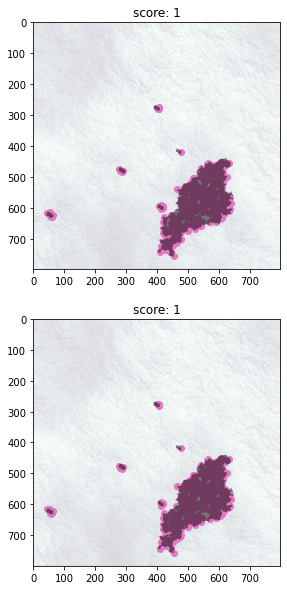

,tpr,fpr,geom
"{'subtractive': 0, 'min_sigma': 0.25, 'max_sigma': 0.35, 'num_sigma': 4, 'threshold': 0.3, 'overlap': 0.5, 'n_neighbors': 2, 'angle_tolerance': 4}",1,0.00684932,"(POINT (53 615), POINT (458 707), POINT (399 2..."
"{'subtractive': 0, 'min_sigma': 0.25, 'max_sigma': 1.0, 'num_sigma': 4, 'threshold': 0.3, 'overlap': 0.5, 'n_neighbors': 2, 'angle_tolerance': 4}",1,0.00684932,"(POINT (53 615), POINT (458 707), POINT (399 2..."


In [13]:
blob_results = compute_cd_metrics(results, function_params, True)
blob_results